# part0: imports

In [7]:
%matplotlib inline

import os, pathlib
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from IPython.display import clear_output

import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        from tools import corrTools as ct
        
        import params
        reload(params)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs
        defs = monkey_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)

    print('Done')

FIGPATH = params.figPath / 'figS1-monkey-behaviour'
if not os.path.exists(FIGPATH):
    os.makedirs(FIGPATH)

Done


---
Get data


In [8]:
@utility.report
def get_1session_monkey_data():
    full_list_MCx = []
    for animal, sessionList in SingleSessionEx.items():
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

    return allDFs_MCx

---
example monkey trajectories

In [9]:
def plot_traj(ax, df):
    df = pyal.restrict_to_interval(df, epoch_fun=monkey_defs.exec_epoch)
    colors = np.roll(utility.get_colors(monkey_defs.n_targets),3,axis=0)
    for i,traj in enumerate(df.pos):
        color = colors[df.target_id[i]]
        ax.plot(traj[:,0], traj[:,1], color=color, lw=.4)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, min_n_ticks=3, nbins=3))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, min_n_ticks=3, nbins=3))
    ax.set_xticklabels(np.int16(ax.get_xticks()-ax.get_xticks().min()))
    ax.set_yticklabels(np.int16(ax.get_yticks()-ax.get_yticks().min()))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('$X (mm)$')
    ax.set_ylabel('$Y (mm)$')

---
plot VAF distrbution

In [10]:
def plot_vaf(ax, df, field='MCx_rates', **kwarg):
    n_components = 20
    
    df_ = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
    
    rates = np.concatenate(df_[field].values, axis=0)
    rates_model = PCA(n_components=n_components, svd_solver='full').fit(rates)
    
    line = ax.plot(np.arange(1,n_components+1), np.cumsum(rates_model.explained_variance_ratio_), **kwarg)

    ax.set_yticks(np.arange(0,1,.2))
    ax.set_ylim([0,.9])
    ax.set_xticks(np.arange(1,n_components+1,3))
    ax.set_xlabel('Neural modes')
    ax.set_ylabel('VAF')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return line

---

Plot the correlation panel

In [11]:
@utility.report
def plot_traj_corr(ax, allDFs_MCx):

    within_corrs_monkeys = ct.trim_within_monkey_corr(allDFs_MCx)

    # plotting
    w_monkey = list(within_corrs_monkeys.values())
    w_monkey = np.array([l for L in w_monkey for l in L])
    ax.hist(w_monkey, density=True, alpha=.8, color=params.colors.MonkeyPts)
    ax.axvline(w_monkey.mean(), color=params.colors.MonkeyPts, zorder=0)
    
    ax.set_yticks([])
    ax.set_xticks([0,1])
    ax.set_xlim([0,1])
    ax.set_ylabel('Probability\ndensity')
    ax.set_xlabel('Behavioural correlation')
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_facecolor('None')
    return within_corrs_monkeys

# Part 2

Plot figure

Executed: `get_1session_monkey_data` in 1.2s


AttributeError: 'list' object has no attribute 'monkey'

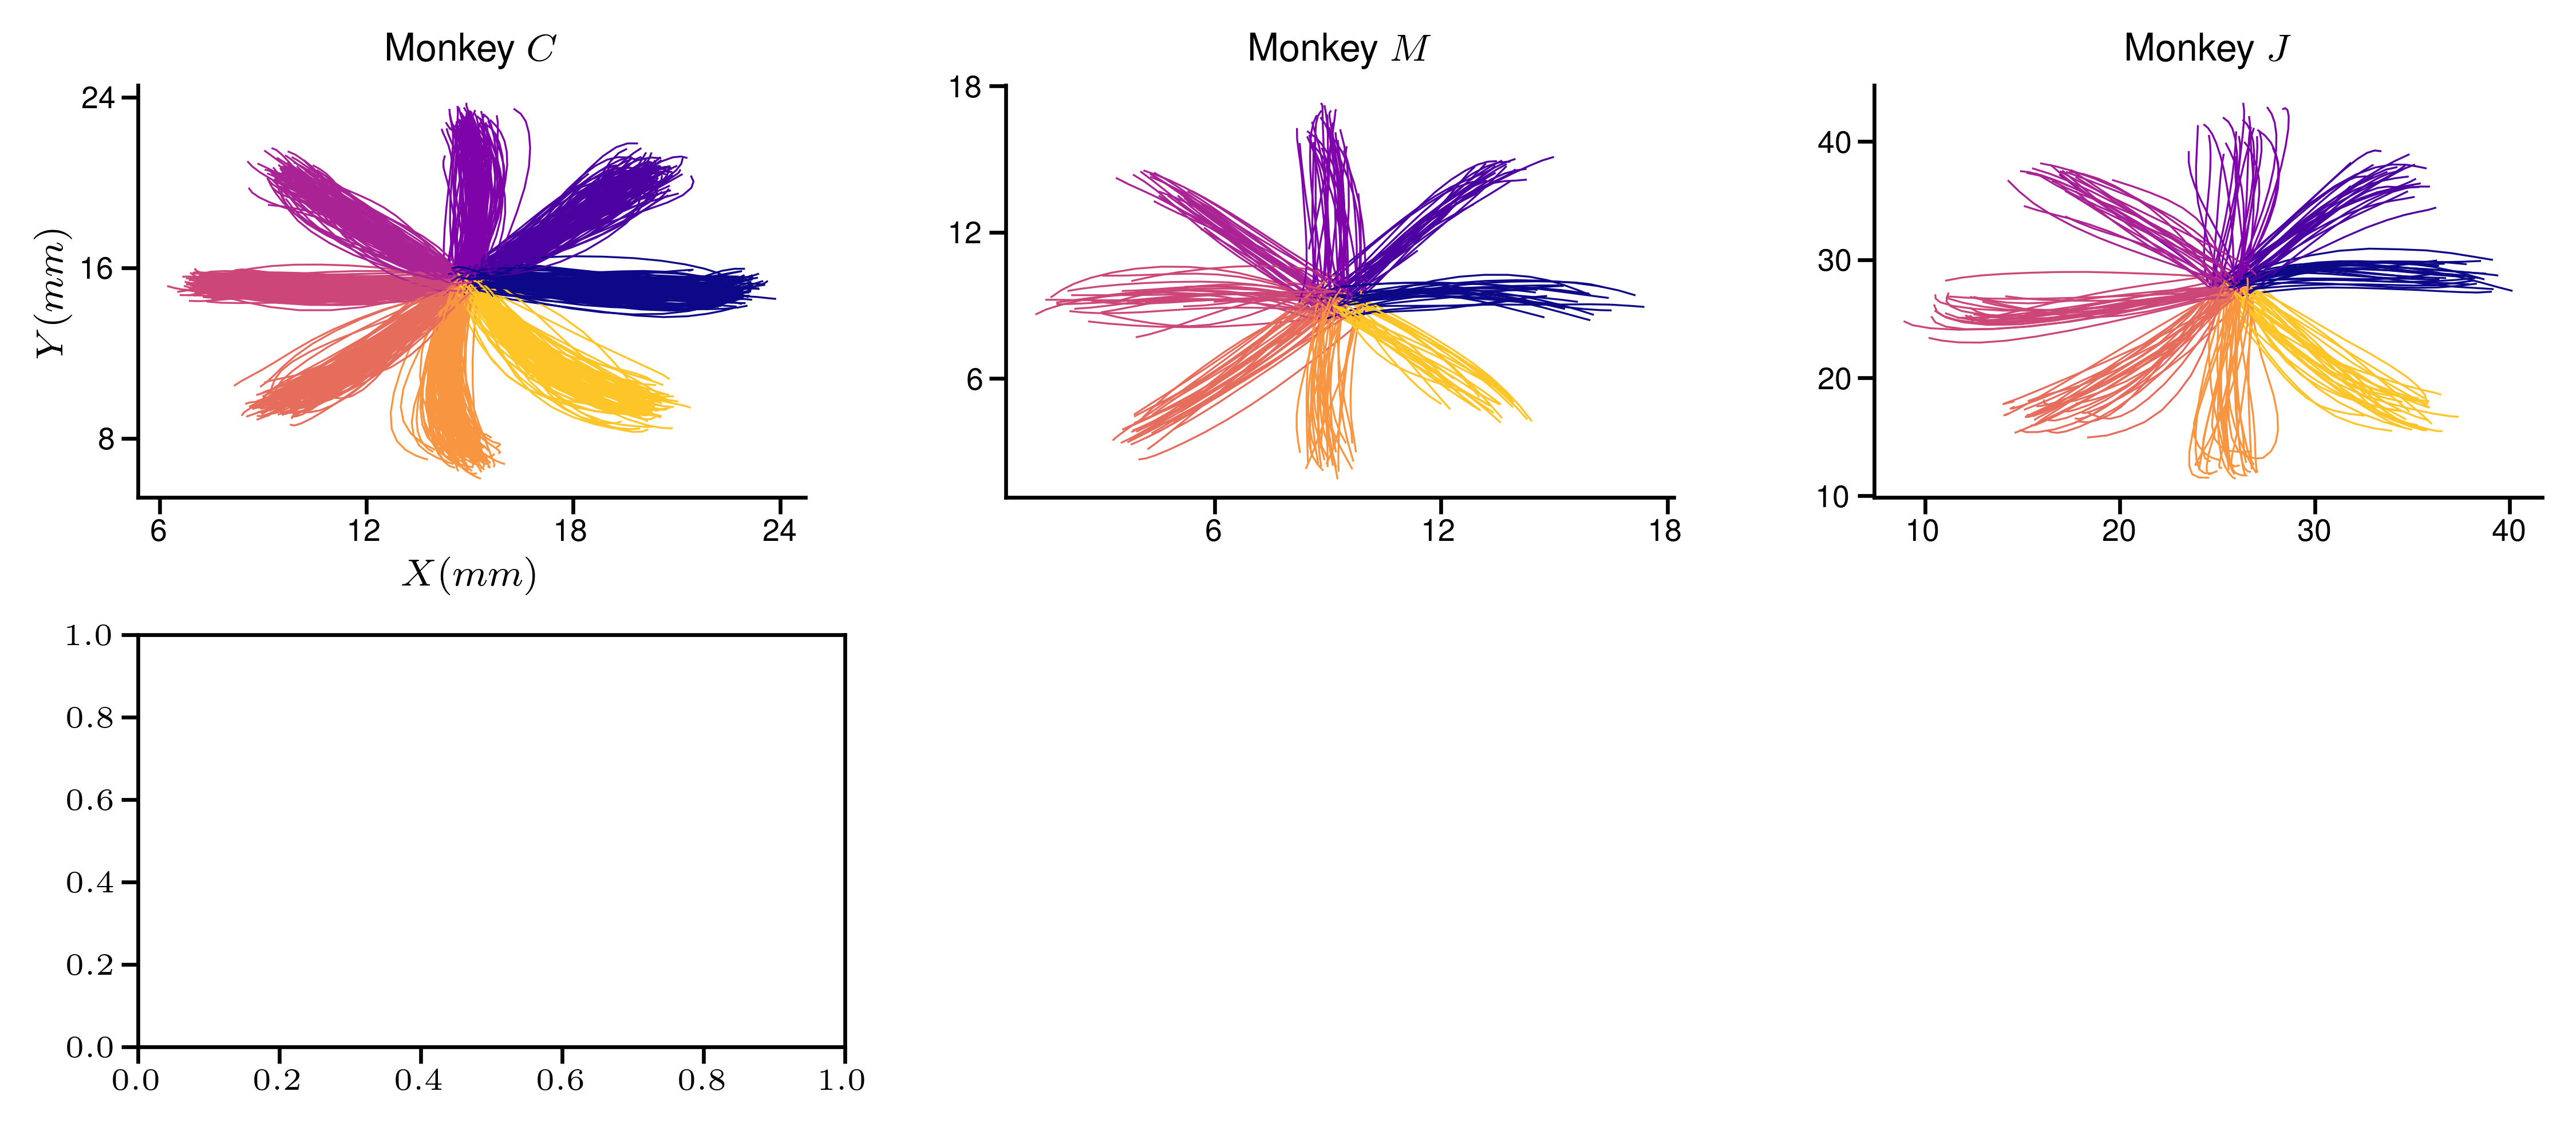

In [12]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    figsize=params.LargeFig
    fig=plt.figure(figsize=figsize)
   
    sessionDFs_MCx = get_1session_monkey_data()
    
    ##########################################
    # 1: trajectories
    gs1   =utility.add_gridspec_abs(fig, nrows=1, ncols=len(sessionDFs_MCx), left=0, 
                                    bottom=figsize[1]-params.panels.SmallH, 
                                    width=figsize[0], 
                                    height=params.panels.SmallH,
                                    wspace=.3)
    
    axes1=[]
    for i, df in enumerate(sessionDFs_MCx):
        axes1.append(ax:=fig.add_subplot(gs1[i]))
        plot_traj(ax, df)
        ax.set_title(f'Monkey ${df.monkey[0][0]}$')
        if i>0:
            ax.set_ylabel('')
            ax.set_xlabel('')


    ##########################################
    # 2: trajectory correlations 
    gs2   =utility.add_gridspec_abs(fig, nrows=1, ncols=len(sessionDFs_MCx), left=0, 
                                    bottom=figsize[1]*gs1.bottom-params.panels.SmallH-.4, 
                                    width=figsize[0], 
                                    height=params.panels.SmallH)
    

    allDFs_MCx = dt.get_full_monkey_data(GoodDataList_CO)

    axes2 = []
    for ind, AX in enumerate(axes1):
        axes2.append(ax:=fig.add_subplot(gs2[ind]))
        title = AX.get_title()[6:]
        DFs = []
        for df in allDFs_MCx:
            if df.monkey[0][0] in title:
                DFs.append(df)

        within_corrs_monkeys = plot_traj_corr(ax, DFs)
        ax.text(np.mean(within_corrs_monkeys[sessionDFs_MCx[ind].session[0]]),
                ax.get_ylim()[1]/2,
                '*', ha='center', va='center', fontsize=12)
        if ind > 0:
            ax.set_ylabel('')
            ax.set_xlabel('')
            

    ##########################################
    # 3: VAF 
    gs3   =utility.add_gridspec_abs(fig, nrows=1, ncols=len(sessionDFs_MCx), left=0, 
                                    bottom=figsize[1]*gs2.bottom-params.panels.SmallH-.4, 
                                    width=figsize[0], 
                                    height=params.panels.SmallH)
    

    axes3=[]
    for i, df in enumerate(sessionDFs_MCx):
        axes3.append(ax:=fig.add_subplot(gs3[i]))
        plot_vaf(ax, df, field = 'MCx_rates', color=params.colors.MouseM1, zorder = 1)
    
    for df in allDFs_MCx:
        for ind, AX in enumerate(axes1):
            if df.monkey[0][0] in AX.get_title()[6:]:
                ax = axes3[ind]
                break

        plot_vaf(ax, df, field = 'MCx_rates', color='gray', zorder = 0, lw=.5)
        ax.set_ylim([0,.9])
    
    for ax in axes3[1:]:
        ax.set_ylabel('')
        ax.set_xlabel('')
    
    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    AXES=(axes1[0],axes2[0],axes3[0])
    OFFX=np.array([.03]*len(AXES))
    OFFY=np.array([.01]*len(AXES))
#     # OFFX[[-1]]=0.12
#     # OFFX[[1]]=0.06
    
    params.add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)

    fig.savefig(FIGPATH / 'figureS1-monkey-behaviour.pdf', format='pdf', bbox_inches='tight')

clear_output()